In [1]:
import os
import glob
import numpy as np
import xarray as xr
import dask
import cftime
import nc_time_axis
import subprocess
import matplotlib.pyplot as plt

In [2]:
def preproc_timeseries(data):
    """ preprocessing routine for EOF timeseries """

    data = data.rename({'time_counter': 'time'})
    data = data.drop_vars({'time_counter_bnds'})
        
    return data

In [3]:
def preproc_pattern(data):
    """ preprocessing routine for EOF pattern """

    data = data.rename_dims({'x_grid_T': 'x', 'y_grid_T': 'y'})
    data = data.rename({'nav_lat_grid_T': 'lat', 'nav_lon_grid_T': 'lon'})
    data = data.rename({'time_counter': 'time'})
    data = data.drop_vars({'time_counter_bnds'})
        
    return data

In [4]:
def preproc_variance(data):
    """ preprocessing routine for EOF variance """

    data = data.rename({'time_counter': 'time'})
    data = data.drop_vars({'time_counter_bnds'})
        
    return data

In [5]:
expname='lfr0'
mainpath=os.path.join("/ec/res4/scratch/itas/eof/")

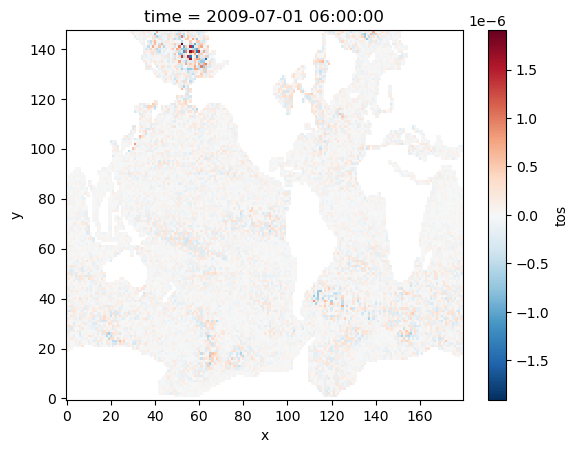

In [6]:
# safe check: verify that EOF can reproduce the last frame
pattern = xr.open_mfdataset(os.path.join(mainpath, 'pattern.nc'), use_cftime=True, preprocess=preproc_pattern)
variance = xr.open_mfdataset(os.path.join(mainpath, 'variance.nc'), use_cftime=True, preprocess=preproc_variance)
scalar = pattern.isel(time=0)*0
for k in range(10):
    filename = os.path.join(mainpath, f"timeseries0000{k}.nc")
    data = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_timeseries)
    ts = data['tos'].isel(time=-1).values.flatten()
    step = pattern.isel(time=k)
    scalar = scalar + ts*step
#scalar['tos'].plot()
data = xr.open_mfdataset(os.path.join(mainpath, "tos_anomaly.nc"), use_cftime=True, preprocess=preproc_pattern)
delta = data['tos'].isel(time=-1) - scalar['tos']
delta.plot()

In [7]:
# apply EOF for forecasting
fdate = cftime.DatetimeGregorian(2019, 7, 1, 6, 0, 0, has_year_zero=False)
xf = xr.DataArray(data = np.array([fdate]), dims = ['time'], coords = {'time': np.array([fdate])}, attrs = {'stardand_name': 'time', 'long_name': 'Time axis', 'bounds': 'time_counter_bnds', 'axis': 'T'})

In [8]:
timeseries = xr.open_mfdataset(os.path.join(mainpath, f"timeseries00000.nc"), use_cftime=True, preprocess=preproc_timeseries)
p = timeseries['tos'].polyfit(dim='time', deg=1, skipna = True)
yf = xr.polyval(xf, p.polyfit_coefficients)
yf

<xarray.DataArray (time: 1, lat: 1, lon: 1)> Size: 8B
dask.array<add, shape=(1, 1, 1), dtype=float64, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 8B 2019-07-01 06:00:00
  * lat      (lat) float64 8B 0.0
  * lon      (lon) float64 8B 0.0

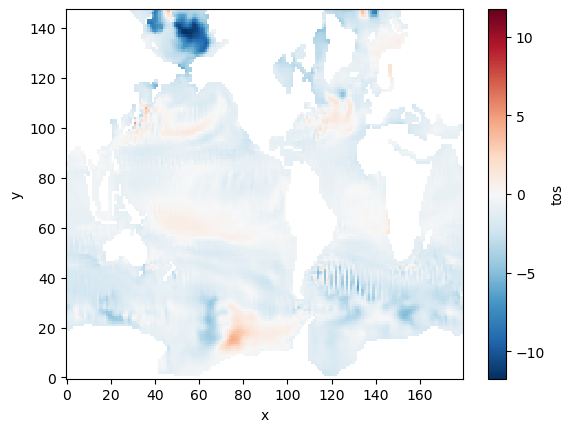

In [9]:
# new method using polyfit
pattern = xr.open_mfdataset(os.path.join(mainpath, 'pattern.nc'), use_cftime=True, preprocess=preproc_pattern)
variance = xr.open_mfdataset(os.path.join(mainpath, 'variance.nc'), use_cftime=True, preprocess=preproc_variance)
scalar = pattern.isel(time=0)*0
for k in range(10):
    filename = os.path.join(mainpath, f"timeseries0000{k}.nc")
    timeseries = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_timeseries)
    p = timeseries['tos'].polyfit(dim='time', deg=1, skipna = True)
    fit = xr.polyval(data['time'], p.polyfit_coefficients)
    yf = xr.polyval(xf, p.polyfit_coefficients)
    step = pattern.isel(time=k)
    scalar = scalar + yf.values.flatten()*step
scalar['tos'].plot()
#plt.ylim(20,60)
#plt.xlim(100,160)

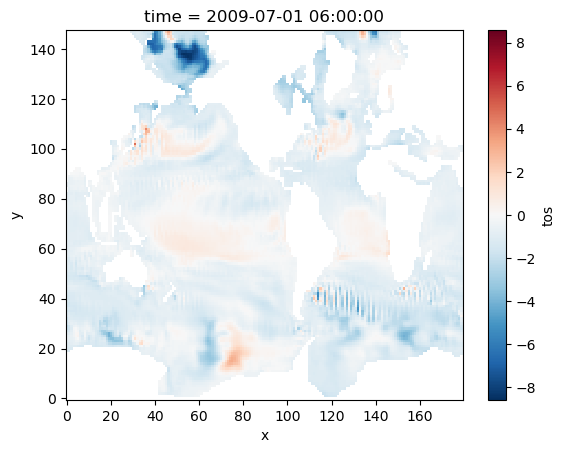

In [10]:
# plot difference between last frame and the forecast
data = xr.open_mfdataset(os.path.join(mainpath, "tos_anomaly.nc"), use_cftime=True, preprocess=preproc_pattern)
delta = scalar['tos'] - data['tos'].isel(time=-1)
delta.plot()

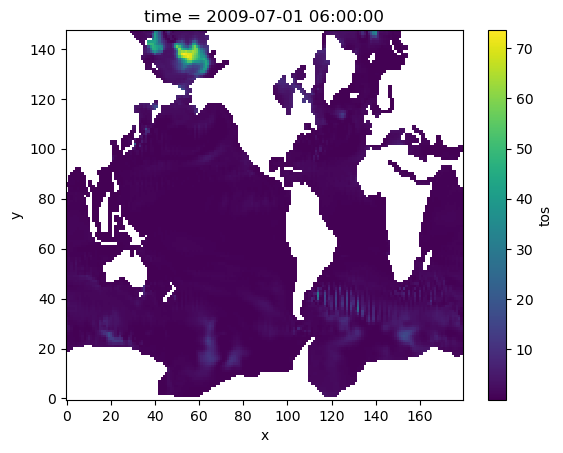

In [11]:
# plot difference between last frame and the forecast
data = xr.open_mfdataset(os.path.join(mainpath, "tos_anomaly.nc"), use_cftime=True, preprocess=preproc_pattern)
delta = np.power(scalar['tos'] - data['tos'].isel(time=-1),2)
delta.plot()